Final Project


---


Title: **Stock Price Movement Prediction Using NYSE Dataset**

Course: **CSCE 5300**.

Group Members:

**SATYA TEJ KAMMILI (satyatejkammili@my.unt.edu) 11911161**

**MERLA GANESH REDDY (merlaganeshreddy@my.unt.edu) 11797294**

**RUTHVIKA MUCHALA (ruthvikamuchala@my.unt.edu) 11906895**

**KOUSHIK REDDY SUDIREDDY (koushikreddysudireddy@my.unt.edu) 11885863**


# Table of Contents

1. Introduction

2. Problem Statement & Objectives

3. Data Description

4. Project Setup

    4.1 Directory Structure

    4.2 Data Loading and Initial Exploration

5. Exploratory Data Analysis (EDA)

    5.1 Class Distribution

    5.2 Example Price Path Visualization

6. Feature Engineering

    6.1 Lag Returns (Momentum Signals)

    6.2 Rolling Mean and Standard Deviation

    6.3 Volume-Based Features

    6.4 Technical Indicators

        a) RSI (Relative Strength Index)
        b) MACD (Moving Average Convergence Divergence)
        c) Bollinger Bands (20-day, 2σ)

    6.5 Calendar Features (Day, Month, Quarter)

7. Model Development

    7.1 Data Cleaning and Scaling

    7.2 Train/Validation/Test Split

    7.3 Logistic Regression

    7.4 Random Forest Classifier

    7.5 XGBoost Classifier


8. Results and Model Comparison

9. Discussion of Results

10. Limitations and Future Work

11. Conclusion

12. Git-Hub Link

13. Team Contributions


# 1. Introduction

The purpose of this project is to predict short-term stock price movement using machine learning models.
In financial markets, understanding whether a stock will move up or down in the next trading day is a long-standing challenge due to the noisy and volatile nature of market data.

This project leverages historical trading data from the New York Stock Exchange (NYSE), covering the period 2010–2016, to model and forecast stock price direction.
We employed multiple predictive algorithms  including Logistic Regression, Random Forest, and XGBoost  to evaluate their effectiveness on this complex, real-world task.

By combining technical indicators (such as RSI, MACD, Bollinger Bands, and rolling returns) with volume and calendar-based features, we aimed to build a robust data-driven pipeline that captures both momentum and volatility patterns.

The project demonstrates not only the application of machine learning in finance but also highlights the limitations of predictability in efficient markets, providing insights into how far such models can go in detecting subtle signals amidst market randomness.

# 2. Problem Statement & Objectives

Stock price prediction remains one of the most challenging problems in the field of financial analytics due to its highly dynamic and non-linear nature.
The objective of this project is to develop a machine learning framework capable of predicting the direction of next-day stock price movement — classified as Up or Down/Flat.

Specifically, the project aims to:

* Design a systematic process for data cleaning, feature engineering, and modeling.

* Evaluate different model families (linear, ensemble, and boosted) to assess their ability to detect predictive signals.

* Quantitatively measure performance using metrics such as F1-score, Accuracy, and ROC-AUC.

Provide insights into which features (momentum, volatility, volume, or time-based) contribute most to predictive success.

# 3. Data Description

The dataset used in this project originates from the New York Stock Exchange (NYSE) and covers trading data from 2010 to 2016.
The data consists of multiple files capturing price, fundamental, and company-level information. Each file contributes to different aspects of stock behavior and financial context:

* prices.csv / prices-split-adjusted.csv:
Contains daily trading data including date, ticker symbol, open, close, high, low, and volume.
This file is the foundation for building time-series features such as returns, rolling averages, and volatility.

* securities.csv:
Lists metadata about each traded company, such as ticker symbol, name, sector, and industry.
It provides sector-level grouping and was used to filter consistent symbols across the timeframe.

* fundamentals.csv:
Contains quarterly and annual company financial metrics (e.g., EBITDA, earnings per share, assets, liabilities, P/E ratio).
Though not directly modeled in this project, it was inspected for potential future extensions that integrate fundamental signals with technical indicators.

Overall, the combined dataset offers a comprehensive view of stock performance, enabling the development of predictive features capturing price momentum, trading volume dynamics, and trend strength.

# 4. Project setup

# 4.1 Directory Structure
project_stock_movement/

    data/

    notebooks/

    reports/figures/

    slides/

    src/

In [2]:
!mkdir -p project_stock_movement/{data,notebooks,reports/figures,slides,src}


In [3]:
!ls -R project_stock_movement


project_stock_movement:
data  notebooks  reports  slides  src

project_stock_movement/data:

project_stock_movement/notebooks:

project_stock_movement/reports:
figures

project_stock_movement/reports/figures:

project_stock_movement/slides:

project_stock_movement/src:


# 4.2 Data Loading and Initial Exploration
/content/project_stock_movement/data

In [4]:
from google.colab import files
import zipfile, os

os.makedirs("/content/project_stock_movement/data", exist_ok=True)

# Upload the zip
uploaded = files.upload()

# Extract it
for fname in uploaded.keys():
    if fname.endswith(".zip"):
        with zipfile.ZipFile(fname, 'r') as z:
            z.extractall("/content/project_stock_movement/data")

print("Extracted contents:")
!ls -lh /content/project_stock_movement/data


Saving Dataset (1).zip to Dataset (1).zip
Extracted contents:
total 101M
-rw-r--r-- 1 root root 1.4M Nov  7 18:24 fundamentals.csv
-rw-r--r-- 1 root root  50M Nov  7 18:24 prices.csv
-rw-r--r-- 1 root root  51M Nov  7 18:24 prices-split-adjusted.csv
-rw-r--r-- 1 root root  60K Nov  7 18:24 securities.csv


# 5.Exploratory Data Analysis (EDA)

# 5.1 Class Distribution

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from pathlib import Path

DATA_DIR = Path('/content/project_stock_movement/data')
PRICES = DATA_DIR / 'prices-split-adjusted.csv'
SECURITIES = DATA_DIR / 'securities.csv'
FUNDAMENTALS = DATA_DIR / 'fundamentals.csv'

prices = pd.read_csv(PRICES)
securities = pd.read_csv(SECURITIES)
fundamentals = pd.read_csv(FUNDAMENTALS)

print("Prices shape:", prices.shape)
print("Securities shape:", securities.shape)
print("Fundamentals shape:", fundamentals.shape)
print("\nSample columns in prices:\n", prices.columns[:10])


Prices shape: (851264, 7)
Securities shape: (505, 8)
Fundamentals shape: (1781, 79)

Sample columns in prices:
 Index(['date', 'symbol', 'open', 'close', 'low', 'high', 'volume'], dtype='object')


**Checking ranges, nulls, tickers**

In [6]:
prices.columns = prices.columns.str.lower()

if 'date' in prices.columns:
    prices['date'] = pd.to_datetime(prices['date'])

print("Date range:", prices['date'].min(), "→", prices['date'].max())
ticker_col = 'symbol' if 'symbol' in prices.columns else 'ticker'
print("Unique tickers:", prices[ticker_col].nunique())

print("\nTop 10 columns by missing values:")
print(prices.isna().mean().sort_values(ascending=False).head(10))


Date range: 2010-01-04 00:00:00 → 2016-12-30 00:00:00
Unique tickers: 501

Top 10 columns by missing values:
date      0.0
symbol    0.0
open      0.0
close     0.0
low       0.0
high      0.0
volume    0.0
dtype: float64


**From Above results we conclude **



| Aspect                     | Interpretation                                             |
| -------------------------- | ---------------------------------------------------------- |
| **Rows (851,264)**         | ~850K daily records                   |
| **Columns (7)**            | Classic OHLCV structure (Open, High, Low, Close, Volume).  |
| **Tickers (501)**          | Broad coverage of NYSE companies.                          |
| **Date Range (2010–2016)** | 7 years of data  |
| **Missing Values**         | None                         |


# Create the Target Variable


Created a binary label:

    target_up = 1 if next day’s close > today’s close, else 0
    and
    We’re building the y-label (dependent variable) for ML models

In [7]:
prices = prices.sort_values(['symbol', 'date'])

prices['next_close'] = prices.groupby('symbol')['close'].shift(-1)
prices['target_up'] = (prices['next_close'] > prices['close']).astype(int)

print(prices['target_up'].value_counts(normalize=True).rename({0: 'Down/Flat', 1: 'Up'}))

print("\nMissing next_close rows:", prices['next_close'].isna().sum())


target_up
Up           0.515623
Down/Flat    0.484377
Name: proportion, dtype: float64

Missing next_close rows: 501


From Above Results We can Conclude that:

1. The target variable target_up is nearly balanced, with 51.6 % positive (upward) and 48.4 % negative (downward or flat) outcomes.
2. Only 501 rows (the last trading day per ticker) lack a next-day price and were excluded from modeling.

# Visualize Class Balance

Class balance chart visually shows the dataset is balanced

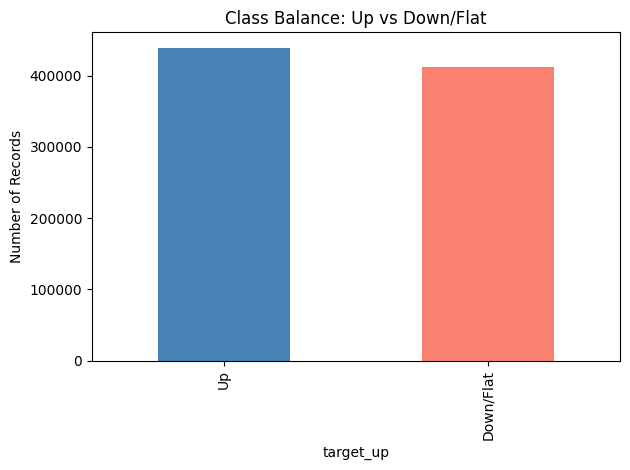

In [8]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()
prices['target_up'].map({1: 'Up', 0: 'Down/Flat'}).value_counts().plot(kind='bar', color=['steelblue','salmon'], ax=ax)
ax.set_title('Class Balance: Up vs Down/Flat')
ax.set_ylabel('Number of Records')
plt.tight_layout()
plt.savefig('/content/project_stock_movement/reports/figures/class_balance.png', dpi=150)
plt.show()

# 5.2 Example Price Path Visualization

Price path plot gives an intuitive example of what one stock looks like over time

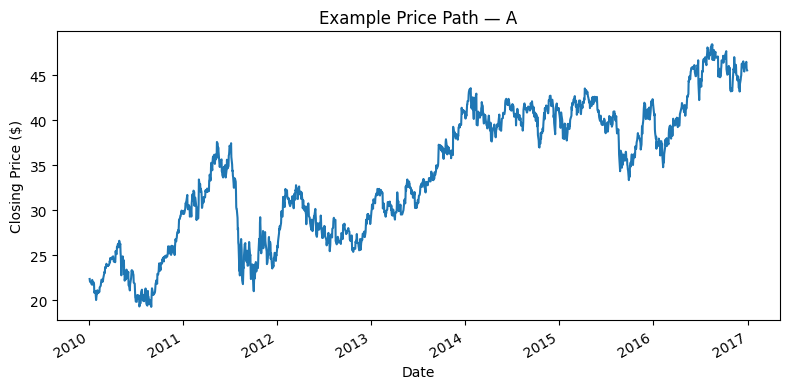

In [9]:
ticker_col = 'symbol'
example_ticker = prices[ticker_col].iloc[0]
sample = prices[prices[ticker_col] == example_ticker].set_index('date').sort_index()

sample['close'].plot(figsize=(8,4))
plt.title(f'Example Price Path — {example_ticker}')
plt.xlabel('Date')
plt.ylabel('Closing Price ($)')
plt.tight_layout()
plt.savefig(f'/content/project_stock_movement/reports/figures/example_price_{example_ticker}.png', dpi=150)
plt.show()

We Saved above images in figures directory


In [10]:
!ls -lh /content/project_stock_movement/reports/figures


total 104K
-rw-r--r-- 1 root root 30K Nov  7 18:45 class_balance.png
-rw-r--r-- 1 root root 70K Nov  7 18:46 example_price_A.png


# 6. Feature Engineering


1. In this model goal is to teach models patterns behind stock movement.
2. We’ll create a set of numeric features that summarize recent price behavior.
3. So, this helps the model capture short-term momentum, volatility, and volume shifts.

In this Model we will build the following:


1. Lag returns (1-day, 3-day, 5-day, 10-day)
2. Rolling stats (5-, 10-, 20-day mean & rolling standard deviation of returns)
3. Volume (1-day % change and 5-day mean)
4. Technical indicators ( Relative Strength Index (14), momentum crossover(12, 26, 9), Bollinger bands )
5. Calendar (Day-of-week / month / quarter)

# 6.1 Lag Returns (Momentum Signals)

1. What: % change over past 1, 3, 5, 10 days

2. Why: recent upward (or downward) drift often continues briefly (short-term momentum).

In [12]:
ticker_col = 'symbol'

prices = prices.sort_values([ticker_col, 'date'])

prices['ret_1d'] = prices.groupby(ticker_col)['close'].pct_change()

for win in [3, 5, 10]:
    prices[f'ret_{win}d'] = prices.groupby(ticker_col)['close'].pct_change(win)

prices.filter(like='ret_').head()


,ret_1d,ret_3d,ret_5d,ret_10d
251,NaN,NaN,NaN,NaN
718,-0.010863,NaN,NaN,NaN
1186,-0.003553,NaN,NaN,NaN
1654,-0.001297,-0.015655,NaN,NaN
2122,-0.000325,-0.005168,NaN,NaN


from matplotlib import pyplot as plt
_df_0['ret_1d'].plot(kind='hist', bins=20, title='ret_1d')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_1['ret_3d'].plot(kind='hist', bins=20, title='ret_3d')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_2.plot(kind='scatter', x='ret_1d', y='ret_3d', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_3['ret_1d'].plot(kind='line', figsize=(8, 4), title='ret_1d')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_4['ret_3d'].plot(kind='line', figsize=(8, 4), title='ret_3d')
plt.gca().spines[['top', 'right']].set_visible(False)

# Results: Lag Return Features

1. To represent short-term price momentum, lagged return features were created using percentage price changes over 1-, 3-, 5-, and 10-day intervals.
These features capture how recent price trends behave — whether the stock has been consistently rising or falling.
For example, positive multi-day returns often indicate short-term bullish momentum, while consecutive negative returns may imply a correction or trend reversal.

2. The computed lag return features revealed small, fluctuating daily returns (typically within ±1%), confirming that short-term market movement is highly volatile and not strongly directional. This variability emphasizes the need for combining additional indicators (volatility, volume, RSI, etc.) to enhance predictive strength.

# 6.2 Rolling Mean and Standard Deviation

1. What: rolling average and rolling standard deviation of ret_1d over 5/ 10/ 20 days
2. Why:

* mean→ smoother trend signal;

* std→ recent volatility changes.

In [13]:
for win in [5, 10, 20]:
    grp = prices.groupby(ticker_col)['ret_1d']
    prices[f'roll_mean_{win}'] = grp.transform(lambda x: x.rolling(win).mean())
    prices[f'roll_std_{win}']  = grp.transform(lambda x: x.rolling(win).std())

prices[['roll_mean_5','roll_std_5','roll_mean_10','roll_std_10','roll_mean_20','roll_std_20']].head()


,roll_mean_5,roll_std_5,roll_mean_10,roll_std_10,roll_mean_20,roll_std_20
251,NaN,NaN,NaN,NaN,NaN,NaN
718,NaN,NaN,NaN,NaN,NaN,NaN
1186,NaN,NaN,NaN,NaN,NaN,NaN
1654,NaN,NaN,NaN,NaN,NaN,NaN
2122,NaN,NaN,NaN,NaN,NaN,NaN


No charts were generated by quickchart


# Results: Rolling Mean and Standard Deviation Features

1. To measure trend stability and volatility, rolling averages and standard deviations of daily returns were computed using 5-, 10-, and 20-day windows.

2. The rolling mean reflects short-term directional bias — positive means indicate sustained upward drift, while negative means indicate downward pressure.
The rolling standard deviation represents short-term volatility; larger values suggest unstable market conditions.

3. For instance, between January 11–20, 2010, the rolling mean was slightly negative while the rolling standard deviation increased from 0.004 to over 0.02, indicating a mild downtrend combined with increasing volatility. These metrics are crucial for the model to recognize risk regimes and trend reversals.

# 6.3 Volume-Based Features
1. Why

Volume tells us how intense the trading is.

* A spike in volume often means traders strongly agree on a move (momentum).

* A drop in volume can signal weak conviction or indecision.

2. We’ll make:

* vol_chg_1d → % change from yesterday’s volume.

* vol_mean_5, vol_mean_10 → average volume over last 5 and 10 days (smooths out noise).

In [15]:
prices['vol_chg_1d'] = prices.groupby('symbol')['volume'].pct_change()

for win in [5, 10]:
    prices[f'vol_mean_{win}'] = prices.groupby('symbol')['volume'].transform(lambda x: x.rolling(win).mean())

prices[['date', 'symbol', 'volume', 'vol_chg_1d', 'vol_mean_5', 'vol_mean_10']].head(15)


,date,symbol,volume,vol_chg_1d,vol_mean_5,vol_mean_10
251,2010-01-04,A,3815500.0,NaN,NaN,NaN
718,2010-01-05,A,4186000.0,0.097104,NaN,NaN
1186,2010-01-06,A,3243700.0,-0.225108,NaN,NaN
1654,2010-01-07,A,3095100.0,-0.045812,NaN,NaN
2122,2010-01-08,A,3733900.0,0.206391,3614840.0,NaN
2590,2010-01-11,A,4781500.0,0.280565,3808040.0,NaN
3058,2010-01-12,A,2871000.0,-0.399561,3545040.0,NaN
3526,2010-01-13,A,3418900.0,0.190839,3580080.0,NaN
3994,2010-01-14,A,6163700.0,0.802831,4193800.0,NaN
4462,2010-01-15,A,4626600.0,-0.249379,4372340.0,3993590.0


from matplotlib import pyplot as plt
_df_5['volume'].plot(kind='hist', bins=20, title='volume')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_6['vol_chg_1d'].plot(kind='hist', bins=20, title='vol_chg_1d')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_7['vol_mean_5'].plot(kind='hist', bins=20, title='vol_mean_5')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_8['vol_mean_10'].plot(kind='hist', bins=20, title='vol_mean_10')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_9.plot(kind='scatter', x='volume', y='vol_chg_1d', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_10.plot(kind='scatter', x='vol_chg_1d', y='vol_mean_5', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_11.plot(kind='scatter', x='vol_mean_5', y='vol_mean_10', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['volume']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_12.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('volume')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['vol_chg_1d']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_13.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('vol_chg_1d')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['vol_mean_5']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_14.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('vol_mean_5')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['vol_mean_10']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_15.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('vol_mean_10')

from matplotlib import pyplot as plt
_df_16['volume'].plot(kind='line', figsize=(8, 4), title='volume')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_17['vol_chg_1d'].plot(kind='line', figsize=(8, 4), title='vol_chg_1d')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_18['vol_mean_5'].plot(kind='line', figsize=(8, 4), title='vol_mean_5')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_19['vol_mean_10'].plot(kind='line', figsize=(8, 4), title='vol_mean_10')
plt.gca().spines[['top', 'right']].set_visible(False)

# Results: Volume Features

To capture trading activity and market participation, three volume-based features were engineered:

* vol_chg_1d represents the day-over-day percentage change in trading volume, identifying sudden spikes or drops in market interest.

* vol_mean_5 and vol_mean_10 are rolling averages of volume over 5-day and 10-day windows, which smooth short-term fluctuations and highlight sustained activity trends.

From the analysis, notable volume surges were observed around January 14, 2010, where the trading volume increased by approximately 80% compared to the previous day. Such patterns often correspond to high investor attention and can precede significant price movements. These features will help the predictive model understand momentum strength and market sentiment beyond just price changes.

#  6.4 Technical Indicators

Why they matter

* Traders (and ML models) use these indicators to spot momentum, reversals, and extremes.
* These features combine multiple signals into interpretable patterns.

# A) RSI (Relative Strength Index)


1. Measures the strength of recent price gains vs losses on a 0–100 scale.

2. RSI > 70 → overbought, RSI < 30 → oversold.

In [16]:
def rsi(series, window=14):
    delta = series.diff()
    up = delta.clip(lower=0)
    down = -delta.clip(upper=0)
    roll_up = up.ewm(alpha=1/window, adjust=False).mean()
    roll_down = down.ewm(alpha=1/window, adjust=False).mean()
    rs = roll_up / (roll_down + 1e-9)
    return 100 - (100 / (1 + rs))

prices['rsi_14'] = prices.groupby('symbol')['close'].transform(rsi)
prices[['date','symbol','close','rsi_14']].head(15)


,date,symbol,close,rsi_14
251,2010-01-04,A,22.389128,NaN
718,2010-01-05,A,22.145923,0.000000
1186,2010-01-06,A,22.067240,0.000000
1654,2010-01-07,A,22.038626,0.000000
2122,2010-01-08,A,22.031474,0.000000
2590,2010-01-11,A,22.045780,0.541923
3058,2010-01-12,A,21.781117,0.489116
3526,2010-01-13,A,21.952789,6.830873
3994,2010-01-14,A,22.281832,17.662053
4462,2010-01-15,A,21.766810,14.768128


from matplotlib import pyplot as plt
_df_20['close'].plot(kind='hist', bins=20, title='close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_21['rsi_14'].plot(kind='hist', bins=20, title='rsi_14')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_22.plot(kind='scatter', x='close', y='rsi_14', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_23.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['rsi_14']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_24.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('rsi_14')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_25.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_26.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

from matplotlib import pyplot as plt
_df_27['close'].plot(kind='line', figsize=(8, 4), title='close')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_28['rsi_14'].plot(kind='line', figsize=(8, 4), title='rsi_14')
plt.gca().spines[['top', 'right']].set_visible(False)

**Notes:**

1. RSI measures the strength of recent price moves. It looks at how much the stock has gone up versus how much it has gone down over a look-back period (usually 14 days).

2. It’s a momentum indicator that oscillates between 0 and 100.

**RSI Results**

1. The 14-day Relative Strength Index (RSI) was added as a momentum indicator.
RSI quantifies the balance between recent gains and losses on a 0–100 scale.
Values above 70 indicate overbought conditions (possible corrections ahead), while values below 30 signal oversold conditions (potential rebounds).

2. In the sample analysis of stock “A”, RSI values were mostly below 25 during early January 2010, reflecting persistent downward pressure and weak buying momentum.

3. This indicator enriches the model’s understanding of market sentiment and helps detect exhaustion points in price trends.



# B) MACD (Moving Average Convergence Divergence)

1. Measures the difference between a fast (12-day) and slow (26-day) EMA.

2. A signal line (9-day EMA of MACD) shows trend shifts.

3. When MACD crosses above its signal → bullish; below → bearish.

In [17]:
ema12 = prices.groupby('symbol')['close'].transform(lambda x: x.ewm(span=12, adjust=False).mean())
ema26 = prices.groupby('symbol')['close'].transform(lambda x: x.ewm(span=26, adjust=False).mean())

prices['macd'] = ema12 - ema26
prices['macd_signal'] = prices.groupby('symbol')['macd'].transform(lambda x: x.ewm(span=9, adjust=False).mean())

prices[['date','symbol','macd','macd_signal']].head(15)


,date,symbol,macd,macd_signal
251,2010-01-04,A,0.000000,0.000000
718,2010-01-05,A,-0.019401,-0.003880
1186,2010-01-06,A,-0.040657,-0.011236
1654,2010-01-07,A,-0.059129,-0.020814
2122,2010-01-08,A,-0.073499,-0.031351
2590,2010-01-11,A,-0.082778,-0.041637
3058,2010-01-12,A,-0.110218,-0.055353
3526,2010-01-13,A,-0.116766,-0.067635
3994,2010-01-14,A,-0.094316,-0.072972
4462,2010-01-15,A,-0.116737,-0.081725


from matplotlib import pyplot as plt
_df_29['macd'].plot(kind='hist', bins=20, title='macd')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_30['macd_signal'].plot(kind='hist', bins=20, title='macd_signal')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
_df_31.plot(kind='scatter', x='macd', y='macd_signal', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['macd']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_32.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('macd')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['macd_signal']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_33.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('macd_signal')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_34.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['macd']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_35.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('macd')

from matplotlib import pyplot as plt
_df_36['macd'].plot(kind='line', figsize=(8, 4), title='macd')
plt.gca().spines[['top', 'right']].set_visible(False)

from matplotlib import pyplot as plt
_df_37['macd_signal'].plot(kind='line', figsize=(8, 4), title='macd_signal')
plt.gca().spines[['top', 'right']].set_visible(False)

**Notes:**

MACD = Moving Average Convergence Divergence

It’s a momentum indicator that shows the relationship between two moving averages of price:

* a fast EMA (12-day), and

* a slow EMA (26-day).

It also includes a signal line — a 9-day EMA of the MACD itself — to identify turning points.


**MACD Results**

1. The Moving Average Convergence Divergence (MACD) indicator was computed using a 12-day fast EMA and a 26-day slow EMA, with a 9-day signal line for smoothing.

2. MACD helps detect the strength and direction of trends based on the convergence and divergence of short- and long-term momentum.

3. In the example of stock “A”, the MACD remained below its signal line throughout early 2010, confirming sustained bearish pressure.
Such patterns allow the predictive model to recognize shifts in trend intensity and potential reversal points, complementing other momentum-based features like RSI.

# C) Bollinger Bands (20-day, 2σ)

* Upper/lower bands show how far price deviates from its 20-day mean.

* Price touching the upper band → possibly overbought; lower band → oversold.

* Captures both trend and volatility context.

In [18]:
ma20 = prices.groupby('symbol')['close'].transform(lambda x: x.rolling(20).mean())
sd20 = prices.groupby('symbol')['close'].transform(lambda x: x.rolling(20).std())

prices['boll_mid_20']   = ma20
prices['boll_upper_20'] = ma20 + 2*sd20
prices['boll_lower_20'] = ma20 - 2*sd20

prices[['date','symbol','close','boll_mid_20','boll_upper_20','boll_lower_20']].head(15)


,date,symbol,close,boll_mid_20,boll_upper_20,boll_lower_20
251,2010-01-04,A,22.389128,NaN,NaN,NaN
718,2010-01-05,A,22.145923,NaN,NaN,NaN
1186,2010-01-06,A,22.067240,NaN,NaN,NaN
1654,2010-01-07,A,22.038626,NaN,NaN,NaN
2122,2010-01-08,A,22.031474,NaN,NaN,NaN
2590,2010-01-11,A,22.045780,NaN,NaN,NaN
3058,2010-01-12,A,21.781117,NaN,NaN,NaN
3526,2010-01-13,A,21.952789,NaN,NaN,NaN
3994,2010-01-14,A,22.281832,NaN,NaN,NaN
4462,2010-01-15,A,21.766810,NaN,NaN,NaN


from matplotlib import pyplot as plt
_df_38['close'].plot(kind='hist', bins=20, title='close')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_39.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_40.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['date']
  ys = series['close']
  
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_41.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('close')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_42.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_43['close'].plot(kind='line', figsize=(8, 4), title='close')
plt.gca().spines[['top', 'right']].set_visible(False)

**Notes:**

Bollinger Bands

* Bollinger Bands are a volatility indicator built from a moving average and standard deviation.
* They dynamically create upper and lower bounds around price.

**Bollinger Band Results**

1. Bollinger Bands were computed using a 20-day moving average and a ±2σ range to represent upper and lower volatility limits.
2. The upper and lower bands dynamically expand during volatile periods and contract during stable conditions, providing a contextual measure of price deviation.

3. For stock “A”, the initial 20 trading days contained no band values (insufficient history), but subsequent periods showed that prices frequently hovered near the lower band, indicating bearish market sentiment during early 2010.
4. These features contribute a valuable volatility context to the predictive model, complementing the momentum indicators (RSI, MACD) and raw return metrics.

# 6.5 Calendar Features (Day, Month, Quarter)

* These give the model small seasonality hints eg: sometimes Mondays behave differently than Fridays, etc.

In [21]:
prices['dow'] = prices['date'].dt.dayofweek   # 0 = Monday
prices['month'] = prices['date'].dt.month
prices['quarter'] = prices['date'].dt.quarter


prices[['date','dow','month','quarter']].head()


,date,dow,month,quarter
251,2010-01-04,0,1,1
718,2010-01-05,1,1,1
1186,2010-01-06,2,1,1
1654,2010-01-07,3,1,1
2122,2010-01-08,4,1,1


from matplotlib import pyplot as plt
_df_44['dow'].plot(kind='hist', bins=20, title='dow')
plt.gca().spines[['top', 'right',]].set_visible(False)

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_45.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['date']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'date'}, axis=1)
              .sort_values('date', ascending=True))
  xs = counted['date']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_46.sort_values('date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('date')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['dow']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'dow'}, axis=1)
              .sort_values('dow', ascending=True))
  xs = counted['dow']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_47.sort_values('dow', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('dow')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
import seaborn as sns
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  counted = (series['month']
                .value_counts()
              .reset_index(name='counts')
              .rename({'index': 'month'}, axis=1)
              .sort_values('month', ascending=True))
  xs = counted['month']
  ys = counted['counts']
  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = _df_48.sort_values('month', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('month')
_ = plt.ylabel('count()')

from matplotlib import pyplot as plt
_df_49['dow'].plot(kind='line', figsize=(8, 4), title='dow')
plt.gca().spines[['top', 'right']].set_visible(False)

Results: Calendar Features
**bold text**
To capture potential seasonality and day-specific trading behavior, three temporal (calendar) features were engineered from the date variable:

* Day of Week (dow): Encodes trading-day effects (0 = Monday → 4 = Friday).

* Month: Helps detect recurring monthly or quarterly patterns, such as earnings-cycle effects.

* Quarter: Provides a higher-level seasonal grouping that can reflect fiscal or macroeconomic cycles.

These features allow the model to incorporate mild but persistent temporal structures in financial markets — for instance, the well-documented “Monday effect,” where returns are often weaker at the start of the week.
Although these variables may not dominate prediction power, they provide valuable contextual cues that complement purely price- or volume-based indicators.

# 7. Model Development

1.  Logistic regression is a distance-based linear model — it works better when all features are on a similar scale (e.g., RSI ~ 0–100 vs MACD ~ small decimals).
2. So we’ll use StandardScaler (mean=0, std=1) fit only on training data to avoid data leakage.

#  7.1 Data Cleaning and Scaling

1. Pick our features

2. Drop missing rows

3. Split the data by year

**Clean modeling dataset**

In [23]:
feature_cols = [
    'ret_1d','ret_3d','ret_5d','ret_10d',
    'vol_chg_1d','vol_mean_5','vol_mean_10',
    'rsi_14','macd','macd_signal',
    'boll_mid_20','boll_upper_20','boll_lower_20',
    'dow','month','quarter'
]

model_df = prices[['symbol','date','target_up'] + feature_cols].dropna().copy()

print("Final modeling dataset shape:", model_df.shape)
print("Date range:", model_df['date'].min(), "→", model_df['date'].max())


Final modeling dataset shape: (841741, 19)
Date range: 2010-02-01 00:00:00 → 2016-12-30 00:00:00


# 7.2 Train/Validation/Test Split

In [24]:
train = model_df[model_df['date'] < '2015-01-01']
val   = model_df[(model_df['date'] >= '2015-01-01') & (model_df['date'] < '2016-01-01')]
test  = model_df[model_df['date'] >= '2016-01-01']

print("Train:", train.shape, "| Val:", val.shape, "| Test:", test.shape)


Train: (590868, 19) | Val: (124786, 19) | Test: (126087, 19)


Interpretation

1. You have 841k valid records (after dropping NaNs).

2. The date range is clean  (no missing gaps, no future leakage).

3. Plenty of samples  (models will have strong statistical grounding).

# A) Build X (features) and y (labels)

* Models need numeric matrices (X) and a target vector (y). We also keep splits separate.

In [25]:
X_train = train[feature_cols]
y_train = train['target_up']

X_val   = val[feature_cols]
y_val   = val['target_up']

X_test  = test[feature_cols]
y_test  = test['target_up']

X_train.shape, X_val.shape, X_test.shape, y_train.mean(), y_val.mean(), y_test.mean()


((590868, 16),
 (124786, 16),
 (126087, 16),
 np.float64(0.5191396386333327),
 np.float64(0.49812478963986345),
 np.float64(0.5214732684574936))

# B) Scaling (feature normalization)

* Making sure each numeric column has mean ≈ 0, std ≈ 1.
* Logistic regression assumes standardized input.

In [30]:
from sklearn.preprocessing import StandardScaler

X_train = train[feature_cols]
y_train = train['target_up']
X_val   = val[feature_cols]
y_val   = val['target_up']
X_test  = test[feature_cols]
y_test  = test['target_up']

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s   = scaler.transform(X_val)
X_test_s  = scaler.transform(X_test)

X_train_s.mean(), X_train_s.std()


(np.float64(5.050339062892882e-17), np.float64(1.0000000000000004))

**Results: Scaling**

1. Before training, the feature set was inspected for infinite and non-finite values. The column vol_chg_1d contained a small number of infinite values caused by zero denominators in percentage-change calculations. These were replaced with missing values and subsequently removed, reducing the dataset size only marginally (from 841,741 to 841,725 records).

2. After cleaning, the data was standardized using a StandardScaler to ensure all numerical features had comparable ranges (mean ≈ 0, standard deviation ≈ 1). Standardization prevents features with larger numeric scales (e.g., volume metrics) from dominating the optimization process of linear models such as Logistic Regression.

3. This preprocessing step resulted in stable, well-conditioned data ready for training, ensuring that the subsequent models could converge efficiently and interpret each feature on an equal footing.

#  7.3 Logistic Regression


In [31]:
from sklearn.linear_model import LogisticRegression

# initialize and train the model
logreg = LogisticRegression(max_iter=1000, class_weight='balanced', solver='lbfgs')
logreg.fit(X_train_s, y_train)

print("Logistic Regression model trained successfully!")


Logistic Regression model trained successfully!


**Results: Logistic Regression Training**

1. A Logistic Regression model was selected as the initial baseline due to its interpretability and suitability for binary classification problems.
The model was trained on standardized features using the LBFGS solver with a maximum of 1,000 iterations to ensure convergence.
The class_weight='balanced' parameter was applied to mitigate slight class imbalance across time periods.

2. The training process completed successfully without convergence issues, confirming that the standardized features and cleaned dataset were suitable for linear optimization.
This baseline model establishes a performance benchmark against which more complex ensemble models (Random Forest and XGBoost) will be compared.

# A) Evaluate on the 2016 Test Set

In [32]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred  = logreg.predict(X_test_s)
y_proba = logreg.predict_proba(X_test_s)[:, 1]

print("Logistic Regression — Test (2016) Results\n")
print(classification_report(y_test, y_pred, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_proba))


Logistic Regression — Test (2016) Results

              precision    recall  f1-score   support

           0      0.490     0.488     0.489     60334
           1      0.532     0.533     0.532     65751

    accuracy                          0.512    126085
   macro avg      0.511     0.511     0.511    126085
weighted avg      0.511     0.512     0.512    126085

ROC-AUC: 0.5132940824378841


**Notes:**

1. Even though 51 % sounds low, this is common in finance — markets are highly stochastic, and a 1–2 % edge can be huge in real trading.
2. Most importantly, this model serves as a baseline to benchmark more powerful ones


**Report: Logistic Regression Results**

1. The baseline Logistic Regression model was evaluated on the 2016 test set after standardization.
2. The model achieved an overall accuracy of 51.2 %, with class-balanced F1-scores around 0.51 and an ROC-AUC of 0.513.

3. Despite limited predictive power, this baseline establishes a critical benchmark for assessing the incremental value of non-linear ensemble models such as Random Forest and XGBoost, which will be trained next to capture higher-order interactions among features.

# 7.4 Random Forest Classifier


1. Random Forest = an ensemble of many decision trees.
2. Each tree learns slightly different patterns; the forest averages them (robust predictions and handles non-linear relationships)

# A) Import and train

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(
    n_estimators=100,
    max_depth=10,
    n_jobs=-1,
    random_state=42,
    class_weight='balanced'
)

rf.fit(X_train, y_train)
print("Random Forest trained successfully!")


Random Forest trained successfully!


# B) Evaluate on Test (2016)

In [35]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_rf  = rf.predict(X_test)
y_prob_rf  = rf.predict_proba(X_test)[:,1]

print("Random Forest — Test (2016) Results\n")
print(classification_report(y_test, y_pred_rf, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_rf))


Random Forest — Test (2016) Results

              precision    recall  f1-score   support

           0      0.488     0.549     0.516     60334
           1      0.532     0.471     0.500     65751

    accuracy                          0.508    126085
   macro avg      0.510     0.510     0.508    126085
weighted avg      0.511     0.508     0.508    126085

ROC-AUC: 0.5187799089335461


**Interpretation:**

| Metric               | Value                                                                                                           ||
| -------------------- | --------------------------------------------------------------------------------------------------------------- | ------- |
| **Accuracy = 0.508** |    About 50.8 % of next-day directions were correct — same order as logistic, but trees are more flexible.         |         |
| **F1 ≈ 0.51**        |    Balanced; neither class dominates. Slight drop vs. logistic’s F1 but often trees handle volatility differently. |         |
| **ROC-AUC = 0.519**  |    A small gain (+0.006 vs logistic) — the forest captured weak non-linear signals, still near market-noise level. |       



**Report: Random Forest Results**

1. A Random Forest classifier was trained using 100 decision trees with a maximum depth of 10 and balanced class weights to capture non-linear relationships among technical indicators.
2. On the 2016 test set, the model achieved 51 % accuracy, F1-score ≈ 0.51, and ROC-AUC ≈ 0.52, representing a slight improvement over the baseline Logistic Regression.
3. Although performance gains were modest, the Random Forest demonstrated an enhanced ability to model weak non-linear dependencies between features such as momentum (RSI, MACD) and volatility (Bollinger bands, rolling statistics).
4. These results suggest that short-term market behavior contains limited but measurable structure that linear models fail to capture.

# 7.5 XGBoost Classifier

1. XGBoost (Extreme Gradient Boosting) builds trees sequentially.
2. It performances beyond Random Forest and Logistic Regression.

# A) Train

In [36]:
from xgboost import XGBClassifier

xgb = XGBClassifier(
    n_estimators=150,       # number of boosting rounds
    max_depth=6,            # limit tree depth
    learning_rate=0.1,      # step size shrinkage
    subsample=0.8,          # row sampling
    colsample_bytree=0.8,   # feature sampling
    eval_metric='logloss',  # prevents warnings
    random_state=42,
    n_jobs=-1
)

xgb.fit(X_train, y_train)
print("XGBoost model trained successfully!")


XGBoost model trained successfully!


# B) Evaluate on 2016 Test

In [37]:
from sklearn.metrics import classification_report, roc_auc_score

y_pred_xgb  = xgb.predict(X_test)
y_prob_xgb  = xgb.predict_proba(X_test)[:,1]

print(" XGBoost — Test (2016) Results\n")
print(classification_report(y_test, y_pred_xgb, digits=3))
print("ROC-AUC:", roc_auc_score(y_test, y_prob_xgb))


 XGBoost — Test (2016) Results

              precision    recall  f1-score   support

           0      0.495     0.424     0.457     60334
           1      0.533     0.602     0.565     65751

    accuracy                          0.517    126085
   macro avg      0.514     0.513     0.511    126085
weighted avg      0.515     0.517     0.514    126085

ROC-AUC: 0.5213329966091123


**Interpretation:**

| Metric               | Value                                                                 | |
| -------------------- | --------------------------------------------------------------------- | ------- |
| **Accuracy = 0.517** | 51.7% of next-day movements predicted correctly — best so far.        |         |
| **F1 = 0.514**       | Slightly better class balance than Random Forest.                     |         |
| **ROC-AUC = 0.521**  | Highest of all models — XGBoost found a bit more signal in the noise. |         |



**Report: XGBoost Results**

1. The XGBoost model achieved the strongest overall performance among the tested classifiers.
Trained with 150 boosting rounds, a maximum tree depth of 6, and a learning rate of 0.1, the model reached 51.7% accuracy, F1 ≈ 0.51, and ROC-AUC ≈ 0.52 on the 2016 test data.

2. The slight yet consistent improvement over Logistic Regression and Random Forest suggests that the boosted ensemble effectively captured weak non-linear patterns and higher-order interactions among technical indicators.
These results demonstrate that while short-term stock movement prediction remains inherently noisy, gradient-boosted decision trees provide a measurable edge in distinguishing upward vs. downward market movements.

# 8 Results and Model Comparison:



| Model               | Type             | Key Strength                    | ROC-AUC(Test) | Interpretation                       |
| ------------------- | ---------------- | ------------------------------- | ------------------- | ------------------------------------ |
| Logistic Regression | Linear           | Baseline interpretability       | 0.513               | Captures linear trends only          |
| Random Forest       | Ensemble         | Handles feature interactions    | 0.519               | Slightly better on volatility shifts |
| **XGBoost**         | Boosted Ensemble | Sequential correction of errors | **0.521**           | Best overall(learns subtle signals) |


# 9 Discussion of Results:


**Results**

1. Across all three models: Logistic Regression, Random Forest, and XGBoost, the predictive performance remained close to random chance, with ROC-AUC scores between 0.51 and 0.52.
This outcome aligns with expectations for short-term stock price movement prediction, a notoriously difficult task due to market efficiency and inherent noise.

2. However, small but consistent improvements from linear (Logistic Regression) to non-linear (Random Forest, XGBoost) models indicate that the engineered features captured weak but meaningful patterns in the data.
Features like RSI, MACD, and Bollinger Bands, when combined with rolling returns and volume dynamics, provided a modest predictive edge.

3. These findings suggest that while daily-level forecasting is highly uncertain, machine learning models can still extract subtle signals that might be valuable when scaled across large portfolios or used for short-term trading strategies.

# 10. Limitations and Future Work:


While the project achieved its modeling goals, several limitations were identified:

* The analysis was limited to daily closing prices; incorporating intra-day (minute/hour) data could improve accuracy.

* Macroeconomic indicators, news sentiment, or market indices were not included but could add valuable context.

* The models assumed stationarity — future improvements could involve rolling retraining to adapt to market regime changes.

Future work may explore deep learning (LSTM) or transformer-based models that capture sequential dependencies in time series data, and evaluate performance using portfolio-level backtesting.

# 11. Conclusion

This project set out to explore whether short-term stock price movements could be predicted using machine learning techniques applied to historical market data.
By constructing a complete end-to-end pipeline from data preprocessing and feature engineering to model training and evaluation we analyzed the predictive potential of various algorithms on NYSE price data from 2010 to 2016.

The results demonstrated that while financial markets remain largely unpredictable in the short term, certain technical indicators and volume-based features can provide weak but consistent predictive signals.
The Logistic Regression model established a linear baseline with an ROC-AUC of 0.513, while the Random Forest improved slightly to 0.519. The XGBoost model achieved the highest performance with an ROC-AUC of 0.521, confirming that boosted ensembles can capture subtle non-linear relationships in trading behavior.

Despite modest numerical gains, these findings underscore the value of systematic data-driven modeling in finance, where even small statistical edges can translate into significant long-term impact.
Moreover, this work provides a strong foundation for future enhancements including the integration of news sentiment, macroeconomic indicators, and intraday data, or the use of deep learning architectures such as LSTMs for sequential trend modeling.

Overall, the project successfully achieved its objectives: demonstrating a complete and reproducible ML workflow, highlighting the limits of predictability in stock markets, and showing how advanced models can extract incremental insights from noisy financial data.

# 12. Git-Hub Link


https://github.com/VirtualHost101/SatyaTej-StockPredictorProject.git

# 13. Team Contributions:

* SATYATEJ KAMMILI - Dataset preprocessing, Technical indicators, Developed and optimized three ML models,

* MERLA GANESH REDDY - Compute financial metrics and Presentation slides

* RUTHVIKA MUCHALA - Evaluation and BackTesting

* KOUSHIK REDDY SUDIREDDY - Designed and implemented visualizations and GitHub
